## Optimization and multiple lineup generator notebook for ETR's Draftkings golf projections.  This notebook uses Google ortools.  

**NOTE: This notebook is for example purposes only and has no guarantees for accuracy.  Use at your own risk.** 



### Contents
1. [Overview](#overview)
2. [Imports](#imports)
3. [Data Loading and Cleaning](#data_loading)
4. [Solver Setup and Results](#solver)
5. [Multiple Lineup Generator](#multi-lineup)

<a id='overview'></a>
## 1. Overview

This notebook requires the user to download ETR's golf projections and Draftkings tournament salaries.  It will output a csv for uploading generated lineups to DK.  It uses a simple random normal adjustment to ETR's projections to generate the multiple lineups.  Raise or lower the standard deviation to widen or narrow the player pool.  

The optimizer solves the n-dimensional 0-1 knapsack problem of roster selection for DFS golf.  A roster of 6 players with a maximum cumulative salary of $50000 is allowed.  This notebook uses Establish The Run's DK Points projections to find the optimal roster.  The projections are available for download through ETR's golf subscription.

The following is the constraint problem setup:

maximize $\sum_{i=1}^n v_i x_i$

subject to 

$\sum_{i=1}^n w_i x_i <= 50000$, 

$\sum_{i=1}^n x_i == 6$,

$x_i \in \{0, 1\}$

Here, $x_i$ is a 0-1 variable representing whether player i is included in the roster.  $v_i$ represents ETR's points projection for player i.  $w_i$ represents the DK salary for player i.

<a id='imports'></a>
## 2. Imports
#### This python notebook uses the pandas, numpy, and ortools packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

<a id='data_loading'></a>
## 3. Data Loading and Cleaning
#### Load ETR's csv download into a pandas dataframe.  Change the folder location if the csv is not in the same folder.  Change the title of the csv to match the current weeks projections.

In [2]:
current_folder = "../projections/"
file_path = current_folder + 'ETR DraftKings Golf Projections-7202022.csv'
df= pd.read_csv(file_path)
df.head()

,Golfer,Rd 1 Tee Time,Rd 2 Tee Time,DK Salary,DK Points,DK Value,DK Ownership,DK Ceiling,Make Cut Odds,Volatility,Slate Name,Slate ID
0,Sungjae Im,7:22,12:32,10000.0,83.8,8.0,20.2%,119.0,0.841,1.9,Sungjae Im,23394630.0
1,Tony Finau,12:32,7:22,10500.0,81.5,6.4,26.4%,116.7,0.829,2.2,Tony Finau,23394628.0
2,Hideki Matsuyama,7:22,12:32,10300.0,79.1,5.2,24.1%,115.6,0.802,3.0,Hideki Matsuyama,23394629.0
3,Maverick Mcnealy,7:55,13:06,9300.0,75.8,6.2,23.3%,112.6,0.766,3.8,Maverick Mcnealy,23394633.0
4,Cameron Tringale,12:21,7:12,8800.0,74.1,6.4,19.8%,109.7,0.760,3.8,Cameron Tringale,23394636.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Golfer         152 non-null    object 
 1   Rd 1 Tee Time  156 non-null    object 
 2   Rd 2 Tee Time  156 non-null    object 
 3   DK Salary      151 non-null    float64
 4   DK Points      156 non-null    float64
 5   DK Value       151 non-null    float64
 6   DK Ownership   156 non-null    object 
 7   DK Ceiling     156 non-null    float64
 8   Make Cut Odds  156 non-null    float64
 9   Volatility     156 non-null    float64
 10  Slate Name     152 non-null    object 
 11  Slate ID       151 non-null    float64
dtypes: float64(7), object(5)
memory usage: 14.8+ KB


In [4]:
# import DK salaries and player ID
current_folder = "../salaries/"
file_path = current_folder + 'DKSalaries-7202022.csv'
df_dk = pd.read_csv(file_path)
df_dk.head()

,Position,Name + ID,Name,ID,Roster Position,Salary,Game Info,TeamAbbrev,AvgPointsPerGame
0,G,Tony Finau (23394628),Tony Finau,23394628,G,10500,3M Open,Golf,67.88
1,G,Hideki Matsuyama (23394629),Hideki Matsuyama,23394629,G,10300,3M Open,Golf,77.32
2,G,Sungjae Im (23394630),Sungjae Im,23394630,G,10000,3M Open,Golf,71.85
3,G,Sahith Theegala (23394631),Sahith Theegala,23394631,G,9800,3M Open,Golf,68.46
4,G,Adam Hadwin (23394632),Adam Hadwin,23394632,G,9600,3M Open,Golf,65.12


In [5]:
# create DK names ID dict
name_ID_dict = {}
names_dk = []
temp_names = df_dk.Name.to_list()
IDs = df_dk.ID.to_list()
i = 0
for name in temp_names:
    temp_name = name.strip()
    temp_name = temp_name.lstrip('**')
    temp_name = temp_name.lower()
    names_dk.append(temp_name)
    name_ID_dict[temp_name] = IDs[i]
    i += 1
print('Number of players in DK Player Pool:', len(names_dk))
# print('ETR names', names_dk)

Number of players in DK Player Pool: 163


In [6]:
df['projected_ownership'] = df['DK Ownership'].str.rstrip('%').astype('float') 
# Put in a minimum ownership of 0.1% for use in product ownership calculation
df.loc[df['projected_ownership'] < 0.1, 'projected_ownership'] = 0.1
df['cut_odds'] = df['Make Cut Odds']#.str.rstrip('%').astype('float')
df.describe()

,DK Salary,DK Points,DK Value,DK Ceiling,Make Cut Odds,Volatility,Slate ID,projected_ownership,cut_odds
count,151.000000,156.000000,151.000000,156.000000,156.000000,156.000000,1.510000e+02,156.000000,156.000000
mean,6944.370861,50.978846,-0.823179,84.185256,0.458801,7.615385,2.339483e+07,3.869872,0.458801
std,892.684025,12.684565,2.197284,16.913517,0.185300,1.774193,5.844295e+02,6.481919,0.185300
min,6000.000000,20.000000,-2.000000,26.900000,0.011000,1.000000,2.339463e+07,0.100000,0.011000
25%,6300.000000,42.650000,-2.000000,77.800000,0.336750,6.700000,2.339467e+07,0.100000,0.336750
50%,6700.000000,51.850000,-2.000000,87.000000,0.489000,8.100000,2.339471e+07,0.500000,0.489000
75%,7200.000000,59.850000,-0.800000,94.425000,0.601250,9.100000,2.339475e+07,4.825000,0.601250
max,10500.000000,83.800000,8.000000,119.000000,0.841000,10.000000,2.339747e+07,26.400000,0.841000


#### Some minimal data cleanup.  May or may not delete players in the field depending on the csv accuracy.

In [7]:
print("Players being deleted due to lack of some data. Manually fix data in CSV if this is not correct. \n\n", 
      df[df.isna().any(axis=1)])
df = df.dropna()

Players being deleted due to lack of some data. Manually fix data in CSV if this is not correct. 

         Golfer Rd 1 Tee Time Rd 2 Tee Time  DK Salary  DK Points  DK Value  \
105        NaN         13:39          8:29        NaN       45.5       NaN   
147        NaN          8:40         13:49        NaN       29.2       NaN   
148        NaN         13:28          8:18        NaN       28.2       NaN   
152        NaN          0:00          0:00        NaN       25.6       NaN   
154  Ted Purdy         14:00          8:51        NaN       23.9       NaN   

    DK Ownership  DK Ceiling  Make Cut Odds  Volatility Slate Name  Slate ID  \
105         0.0%        80.3          0.386         9.2        NaN       NaN   
147         0.0%        56.0          0.115         7.4        NaN       NaN   
148         0.0%        43.6          0.100         6.8        NaN       NaN   
152         0.0%        32.1          0.062         5.1        NaN       NaN   
154         0.0%        30.7   

#### Load data into lists for the solver.  Change data to integers and adjust data scale.

In [8]:
# Adjust salary and points for solver use.
salary_divisor = 100
dk_points_multiplier = 10
salaries = df['DK Salary'].values / salary_divisor
salaries = [int(w) for w in salaries]
dk_points = df['DK Points'].values
dk_points = [int(i * dk_points_multiplier) for i in dk_points]
ceiling = df['DK Ceiling'].values
ceiling = [int(i * dk_points_multiplier) for i in ceiling]
temp_etr_names =  df['Golfer'].to_list()
print('Check for equal lengths:', len(salaries), len(dk_points), len(temp_etr_names), len(ceiling))

Check for equal lengths: 151 151 151 151


In [9]:
names = []
for name in temp_etr_names:
    temp_name = name.strip()
    temp_name = temp_name.lstrip('**')
    temp_name = temp_name.lower()
    names.append(temp_name)
print('Number of players to use in optimizer:', len(names))
# print('ETR names', names)

Number of players to use in optimizer: 151


In [10]:
# see what names in the field are missing from ETR projections
golfers = set()
not_in = set()
for name in names_dk:
    for golfer in names:
        if golfer in name:
            golfers.add(name)
        else:
            not_in.add(name)
print('Number of common golfers:', len(golfers))
print('Number of golfers in DK field:', len(not_in))
print("Players in DraftKings pool not in ETR predcitions:", not_in.difference(golfers))

Number of common golfers: 151
Number of golfers in DK field: 163
Players in DraftKings pool not in ETR predcitions: {'mark hubbard', 'mo lim', 'jonathan kaye', 'mark hensby', 'duffy waldorf', 'daniel chopra', 'danny lee', 'charles howell iii', 'erik van rooyen', 'charlie beljan', 'eric axley', 'andres romero'}


In [11]:
df['rd1_time'] = pd.to_datetime(df.loc[:,'Rd 1 Tee Time'], format="%H:%M")
df['rd1_tee_time_category'] = pd.cut(df.rd1_time.dt.hour,
       bins=[i for i in range(24)],
       labels=[i for i in range(23)],
       right=False,
       include_lowest=True)

tee_time_1 = df['rd1_tee_time_category'].values
df.head()

,Golfer,Rd 1 Tee Time,Rd 2 Tee Time,DK Salary,DK Points,DK Value,DK Ownership,DK Ceiling,Make Cut Odds,Volatility,Slate Name,Slate ID,projected_ownership,cut_odds,rd1_time,rd1_tee_time_category
0,Sungjae Im,7:22,12:32,10000.0,83.8,8.0,20.2%,119.0,0.841,1.9,Sungjae Im,23394630.0,20.2,0.841,1900-01-01 07:22:00,7
1,Tony Finau,12:32,7:22,10500.0,81.5,6.4,26.4%,116.7,0.829,2.2,Tony Finau,23394628.0,26.4,0.829,1900-01-01 12:32:00,12
2,Hideki Matsuyama,7:22,12:32,10300.0,79.1,5.2,24.1%,115.6,0.802,3.0,Hideki Matsuyama,23394629.0,24.1,0.802,1900-01-01 07:22:00,7
3,Maverick Mcnealy,7:55,13:06,9300.0,75.8,6.2,23.3%,112.6,0.766,3.8,Maverick Mcnealy,23394633.0,23.3,0.766,1900-01-01 07:55:00,7
4,Cameron Tringale,12:21,7:12,8800.0,74.1,6.4,19.8%,109.7,0.760,3.8,Cameron Tringale,23394636.0,19.8,0.760,1900-01-01 12:21:00,12


In [12]:
gb = df.groupby('rd1_tee_time_category')
gb['DK Points'].describe(include=[6, 7]).dropna()

,count,mean,std,min,25%,50%,75%,max
rd1_tee_time_category,,,,,,,,
0,3.0,34.000000,14.525839,20.0,26.500,33.00,41.000,49.0
6,6.0,45.816667,14.831509,29.3,33.225,44.90,58.075,64.0
7,36.0,55.975000,13.854022,24.1,49.300,58.55,65.225,83.8
8,28.0,49.439286,9.994122,27.6,43.200,49.75,55.350,69.3
9,4.0,46.600000,8.064738,35.0,44.900,48.90,50.600,53.6
12,36.0,53.955556,12.834383,28.1,45.025,54.50,62.350,81.5
13,28.0,49.607143,9.545599,31.7,43.475,50.75,57.800,65.0
14,10.0,50.620000,9.081948,33.1,45.075,51.60,54.650,65.5


In [13]:
# Load data in dictionary for the solver.
data = {}
data['ownership'] = df['projected_ownership'].values
data['weights'] = salaries
data['values'] = dk_points 
data['points'] = dk_points
data['ceiling'] = ceiling
data['dk_value'] = df['DK Value'].values
data['dk_value_as_int'] = [int(c*1000) for c in df['DK Value'].values]
data['sigma'] = df['Volatility'].values
data['num_items'] = len(data['weights'])
data['all_items'] = range(data['num_items'])
data['cut_odds'] = df['cut_odds'].values
data['cut_odds_as_int'] = [int(c*1000) for c in df['cut_odds'].values]
data['names'] = names
data['max_weight'] = 500
data['max_items'] = 6

<a id='solver'></a>
## 4. Solve For DK Points and Ceiling Optimal Rosters

#### Use the third party solver SCIP, which is included in ortools.  Information on SCIP [here.](https://www.scipopt.org)

### Optimal based on DK Points projection.

In [14]:
solver = pywraplp.Solver.CreateSolver('SCIP')

# 0/1 variable to show which item is included in the roster.
x = {}
for i in data['all_items']:
    x[i] = solver.BoolVar(f'x_{i}')
    
# Constraints
# Constrain to roster of 6 spots.
solver.Add(sum(x[i] for i in data['all_items']) == data['max_items'])
# Constrain to max salary <= 50000
solver.Add(sum([x[i] * data['weights'][i] for i in data['all_items']]) <= data['max_weight'])

# Objective Function
objective = solver.Objective()
for i in data['all_items']:
    objective.SetCoefficient(x[i], data['values'][i])
objective.SetMaximization()

# Solve
solver_parameters = pywraplp.MPSolverParameters()
solver_parameters.SetDoubleParam(pywraplp.MPSolverParameters.PRIMAL_TOLERANCE, 0.0001)
status = solver.Solve(solver_parameters)

# Results of solver.
if status == pywraplp.Solver.OPTIMAL:
    print(f'Optimal Points: {(objective.Value() / dk_points_multiplier):.2f}')
    total_weight = 0
    product_ownership = 1
    estimate_cut_odds = 1
    for i in data['all_items']:
        if x[i].solution_value() > 0:
            player_salary = data['weights'][i] * salary_divisor
            points = data['points'][i] / dk_points_multiplier
            print(
                f"{data['names'][i]:20} salary: {player_salary:5} points: {points:.1f} ownership: {data['ownership'][i]:5} cut odds: {data['cut_odds'][i]}"
            )
            total_weight += player_salary
            product_ownership *= data['ownership'][i]
            estimate_cut_odds *= (data['cut_odds'][i] )

    print(f'Total Salary: {total_weight}')
    print(f'Projected Product Ownership: {product_ownership:,.0f}')
    print(f'Probability Estimate All 6 To Make Cut: {(estimate_cut_odds*100):.2f}%')
    print('\n')

Optimal Points: 436.90
sungjae im           salary: 10000 points: 83.8 ownership:  20.2 cut odds: 0.841
maverick mcnealy     salary:  9300 points: 75.8 ownership:  23.3 cut odds: 0.766
cameron tringale     salary:  8800 points: 74.1 ownership:  19.8 cut odds: 0.76
joohyung kim         salary:  7300 points: 71.5 ownership:  21.2 cut odds: 0.732
matthew nesmith      salary:  7500 points: 66.5 ownership:  12.8 cut odds: 0.684
tom hoge             salary:  7100 points: 65.2 ownership:  10.3 cut odds: 0.664
Total Salary: 50000
Projected Product Ownership: 26,046,870
Probability Estimate All 6 To Make Cut: 16.28%




### Find Optimal Using Ceiling

In [15]:
ceiling_solver = pywraplp.Solver.CreateSolver('SCIP')
x = {}
for i in data['all_items']:
    x[i] = ceiling_solver.BoolVar(f'x_{i}')

# Constraints
# Constrain to roster of 6 spots.
ceiling_solver.Add(sum(x[i] for i in data['all_items']) == data['max_items'])
# Constrain to max salary <= 50000
ceiling_solver.Add(sum([x[i] * data['weights'][i] for i in data['all_items']]) <= data['max_weight'])

# Objective Function
objective = ceiling_solver.Objective()
for i in data['all_items']:
    objective.SetCoefficient(x[i], data['ceiling'][i])
objective.SetMaximization()

# Solve
solver_parameters = pywraplp.MPSolverParameters()
solver_parameters.SetDoubleParam(pywraplp.MPSolverParameters.PRIMAL_TOLERANCE, 0.0001)
status = ceiling_solver.Solve(solver_parameters)

# Results of solver.
if status == pywraplp.Solver.OPTIMAL:
    print(f'Optimal Ceiling: {(objective.Value() / dk_points_multiplier):.2f}')
    total_weight = 0
    product_ownership = 1
    estimate_cut_odds = 1
    for i in data['all_items']:
        if x[i].solution_value() > 0:
            player_salary = data['weights'][i] * salary_divisor
            points = data['ceiling'][i] / dk_points_multiplier
            print(
                f"{data['names'][i]:20} salary: {player_salary:5} ceiling: {points:.1f} ownership: {data['ownership'][i]:5} cut odds: {data['cut_odds'][i]}"
            )
            total_weight += player_salary
            product_ownership *= data['ownership'][i]
            estimate_cut_odds *= (data['cut_odds'][i] )

    print(f'Total Salary: {total_weight}')
    print(f'Projected Product Ownership: {product_ownership:,.0f}')
    print(f'Probability Estimate All 6 To Make Cut: {(estimate_cut_odds*100):.2f}%')
    print('\n')

Optimal Ceiling: 651.90
sungjae im           salary: 10000 ceiling: 119.0 ownership:  20.2 cut odds: 0.841
maverick mcnealy     salary:  9300 ceiling: 112.6 ownership:  23.3 cut odds: 0.766
cameron davis        salary:  8900 ceiling: 110.4 ownership:  22.4 cut odds: 0.733
joohyung kim         salary:  7300 ceiling: 108.1 ownership:  21.2 cut odds: 0.732
troy merritt         salary:  7400 ceiling: 101.3 ownership:  12.9 cut odds: 0.659
tom hoge             salary:  7100 ceiling: 100.5 ownership:  10.3 cut odds: 0.664
Total Salary: 50000
Projected Product Ownership: 29,697,378
Probability Estimate All 6 To Make Cut: 15.12%




### Find optimal using cut odds

In [16]:
cut_odds_solver = pywraplp.Solver.CreateSolver('SCIP')
x = {}
for i in data['all_items']:
    x[i] = cut_odds_solver.BoolVar(f'x_{i}')

# Constraints
# Constrain to roster of 6 spots.
cut_odds_solver.Add(sum(x[i] for i in data['all_items']) == data['max_items'])
# Constrain to max salary <= 50000
cut_odds_solver.Add(sum([x[i] * data['weights'][i] for i in data['all_items']]) <= data['max_weight'])

# Objective Function
objective = cut_odds_solver.Objective()
for i in data['all_items']:
    objective.SetCoefficient(x[i], data['cut_odds_as_int'][i])
objective.SetMaximization()

# Solve
solver_parameters = pywraplp.MPSolverParameters()
solver_parameters.SetDoubleParam(pywraplp.MPSolverParameters.PRIMAL_TOLERANCE, 0.0001)
status = cut_odds_solver.Solve(solver_parameters)

# Results of solver.
if status == pywraplp.Solver.OPTIMAL:
    print(f'Optimal Cut Odds')#: {objective.Value():.2f}')
    total_weight = 0
    product_ownership = 1
    estimate_cut_odds = 1
    for i in data['all_items']:
        if x[i].solution_value() > 0:
            player_salary = data['weights'][i] * salary_divisor
            cut_odds = data['cut_odds'][i] 
            print(
                f"{data['names'][i]:20} salary: {player_salary:5} ownership: {data['ownership'][i]:5} cut odds: {data['cut_odds'][i]}"
            )
            total_weight += player_salary
            product_ownership *= data['ownership'][i]
            estimate_cut_odds *= (data['cut_odds'][i] )

    print(f'Total Salary: {total_weight}')
    print(f'Projected Product Ownership: {product_ownership:,.0f}')
    print(f'Probability Estimate All 6 To Make Cut: {(estimate_cut_odds*100):.2f}%')
    print('\n')

Optimal Cut Odds
sungjae im           salary: 10000 ownership:  20.2 cut odds: 0.841
maverick mcnealy     salary:  9300 ownership:  23.3 cut odds: 0.766
cameron tringale     salary:  8800 ownership:  19.8 cut odds: 0.76
joohyung kim         salary:  7300 ownership:  21.2 cut odds: 0.732
matthew nesmith      salary:  7500 ownership:  12.8 cut odds: 0.684
tom hoge             salary:  7100 ownership:  10.3 cut odds: 0.664
Total Salary: 50000
Projected Product Ownership: 26,046,870
Probability Estimate All 6 To Make Cut: 16.28%




### Find optimal using value

In [17]:
value_solver = pywraplp.Solver.CreateSolver('SCIP')
x = {}
for i in data['all_items']:
    x[i] = value_solver.BoolVar(f'x_{i}')

# Constraints
# Constrain to roster of 6 spots.
value_solver.Add(sum(x[i] for i in data['all_items']) == data['max_items'])
# Constrain to max salary <= 50000
value_solver.Add(sum([x[i] * data['weights'][i] for i in data['all_items']]) <= data['max_weight'])

# Objective Function
objective = value_solver.Objective()
for i in data['all_items']:
    objective.SetCoefficient(x[i], data['dk_value_as_int'][i])
objective.SetMaximization()

# Solve
solver_parameters = pywraplp.MPSolverParameters()
solver_parameters.SetDoubleParam(pywraplp.MPSolverParameters.PRIMAL_TOLERANCE, 0.0001)
status = value_solver.Solve(solver_parameters)

# Results of solver.
if status == pywraplp.Solver.OPTIMAL:
    print(f'Optimal Value: {objective.Value()/1000:.2f}')
    total_weight = 0
    product_ownership = 1
    estimate_cut_odds = 1
    for i in data['all_items']:
        if x[i].solution_value() > 0:
            player_salary = data['weights'][i] * salary_divisor
            value = data['dk_value'][i] 
            print(
                f"{data['names'][i]:20} salary: {player_salary:5} value: {value:.1f} ownership: {data['ownership'][i]:5} cut odds: {data['cut_odds'][i]}"
            )
            total_weight += player_salary
            product_ownership *= data['ownership'][i]
            estimate_cut_odds *= (data['cut_odds'][i])

    print(f'Total Salary: {total_weight}')
    print(f'Projected Product Ownership: {product_ownership:,.0f}')
    print(f'Probability Estimate All 6 To Make Cut: {(estimate_cut_odds*100):.2f}%')
    print('\n')

Optimal Value: 34.50
sungjae im           salary: 10000 value: 8.0 ownership:  20.2 cut odds: 0.841
cameron tringale     salary:  8800 value: 6.4 ownership:  19.8 cut odds: 0.76
cameron davis        salary:  8900 value: 5.5 ownership:  22.4 cut odds: 0.733
joohyung kim         salary:  7300 value: 7.0 ownership:  21.2 cut odds: 0.732
emiliano grillo      salary:  7600 value: 4.8 ownership:  10.9 cut odds: 0.687
troy merritt         salary:  7400 value: 2.8 ownership:  12.9 cut odds: 0.659
Total Salary: 50000
Projected Product Ownership: 26,706,480
Probability Estimate All 6 To Make Cut: 15.53%




<a id='multi-lineup'></a>
## 5. Generate multiple lineups.

### Create multiple lineups using player projections as a base.  
Adjust the base by sampling from the normal distribution using the points projection as a mean and an arbitrary standard deviation.  

In [18]:
def create_multiple_lineups(data, player_counts, data_to_maximize='values'):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    x = {}
    for i in data['all_items']:
        x[i] = solver.BoolVar(f'x_{i}')
    # Constraints
    # Constrain to roster of 6 spots.
    solver.Add(sum(x[i] for i in data['all_items']) == data['max_items'])
    # Constrain to max salary <= 50000
    solver.Add(sum([x[i] * data['weights'][i] for i in data['all_items']]) <= data['max_weight'])
    objective = solver.Objective()
    for i in data['all_items']:
        objective.SetCoefficient(x[i], data[data_to_maximize][i])
    objective.SetMaximization()
    solver_parameters = pywraplp.MPSolverParameters()
    solver_parameters.SetDoubleParam(pywraplp.MPSolverParameters.PRIMAL_TOLERANCE, 0.0001)
    status = solver.Solve(solver_parameters)
    # Results of solver.
    player_list = []
    if status == pywraplp.Solver.OPTIMAL:
#         print(f'Adjusted Total Points: {(objective.Value() / dk_points_multiplier):.2f}')
        total_weight = 0
        product_ownership = 1
        estimate_cut_odds = 1
        sum_ownership = 0
        for i in data['all_items']:
            if x[i].solution_value() > 0:
                player_counts[data['names'][i]] += 1
                player_list.append(data['names'][i])
                player_salary = data['weights'][i] * salary_divisor
                points = data[data_to_maximize][i] / dk_points_multiplier
                print(
                    f"{data['names'][i]:20} salary: {player_salary:5} points(adj): {points:5.1f} ownership: {data['ownership'][i]:5} cut odds: {data['cut_odds'][i]}"
                )
                total_weight += player_salary
                product_ownership *= data['ownership'][i]
                sum_ownership += data['ownership'][i]
                estimate_cut_odds *= (data['cut_odds'][i])

        print(f'Total Salary: {total_weight}')
        print(f'Projected Product Ownership: {product_ownership:,.0f}')
        print(f'Projected Sum Ownership: {sum_ownership:,.0f}')
        print(f'Probability Estimate All 6 To Make Cut: {(estimate_cut_odds*100):.2f}%')
        print('\n')
    else:
        print('The problem does not have an optimal solution.')
    return player_counts, player_list, (estimate_cut_odds, total_weight, product_ownership)

In [19]:
number_lineups_to_generate = 15

# Adjust sigma up or down to widen or narrow player pool 
sigma = 100

player_counts = {player: 0 for player in data['names']}
multiple_lineups = []
multiple_lineups_data = []
for i in range(number_lineups_to_generate):
    
    # here is where the player projections are adjusted
    data['values'] = np.random.normal(data['points'], sigma)
#     print(data['values'] - data['points'])
    print(f'Roster: {i}')
    player_counts, players, lineup_data = create_multiple_lineups(data, player_counts, data_to_maximize='values')
    multiple_lineups.append(players)
    multiple_lineups_data.append(lineup_data)

Roster: 0
tony finau           salary: 10500 points(adj):  95.1 ownership:  26.4 cut odds: 0.829
maverick mcnealy     salary:  9300 points(adj):  83.7 ownership:  23.3 cut odds: 0.766
adam long            salary:  8600 points(adj):  77.5 ownership:  16.5 cut odds: 0.671
troy merritt         salary:  7400 points(adj):  77.2 ownership:  12.9 cut odds: 0.659
rickie fowler        salary:  7700 points(adj):  82.6 ownership:   6.8 cut odds: 0.62
dawie van der walt   salary:  6200 points(adj):  69.8 ownership:   0.1 cut odds: 0.336
Total Salary: 49700
Projected Product Ownership: 89,031
Projected Sum Ownership: 86
Probability Estimate All 6 To Make Cut: 5.85%


Roster: 1
sungjae im           salary: 10000 points(adj):  90.0 ownership:  20.2 cut odds: 0.841
hideki matsuyama     salary: 10300 points(adj):  91.6 ownership:  24.1 cut odds: 0.802
joohyung kim         salary:  7300 points(adj):  79.0 ownership:  21.2 cut odds: 0.732
matthew nesmith      salary:  7500 points(adj):  81.4 ownership:  

In [20]:
# for lineup in multiple_lineups:
#     print(lineup)
# for d in multiple_lineups_data:
#     print(d)

### Create csv for upload to DK.

In [21]:
# Make rosters in valid csv for upload
multiple_lineups_ids = []

for lineup in multiple_lineups:
    lineup_ids = []
    for golfer in lineup:
        lineup_ids.append(name_ID_dict[golfer])
        
    multiple_lineups_ids.append(lineup_ids)
        
lineups = pd.DataFrame(multiple_lineups_ids)
lineups.to_csv('dk_lineups_pga.csv', index=False, header=['G' for g in range(6)])

In [22]:
# player counts
counts_small = pd.Series(player_counts)
print(counts_small.sort_values(ascending=False).to_string())
   

sungjae im              6
tony finau              6
hideki matsuyama        5
maverick mcnealy        5
troy merritt            5
martin laird            4
matthew nesmith         4
cameron tringale        3
john huh                3
joohyung kim            3
adam hadwin             3
tom hoge                3
rickie fowler           2
hank lebioda            2
adam svensson           2
nate lashley            2
adam long               2
chris gotterup          2
chez reavie             2
emiliano grillo         2
brendan steele          2
cameron davis           2
stewart cink            1
sam ryder               1
dawie van der walt      1
matt wallace            1
adam schenk             1
paul barjon             1
kramer hickok           1
lucas glover            1
ryan palmer             1
matthias schwab         1
hayden buckley          1
bill haas               1
wyndham clark           1
brendon todd            1
andrew putnam           1
stephan jaeger          1
brice garnet

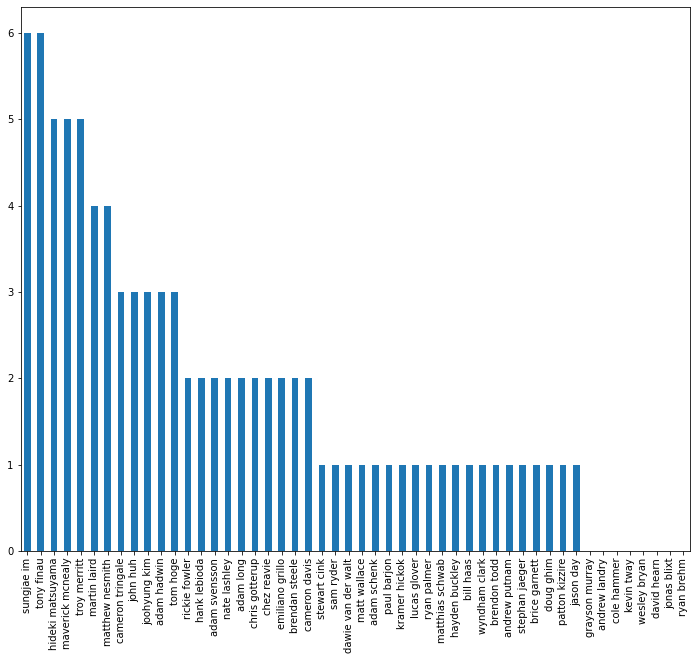

In [23]:
counts_small.sort_values(ascending=False).iloc[:50].T.plot(kind="bar", figsize=(12, 10))
plt.show()

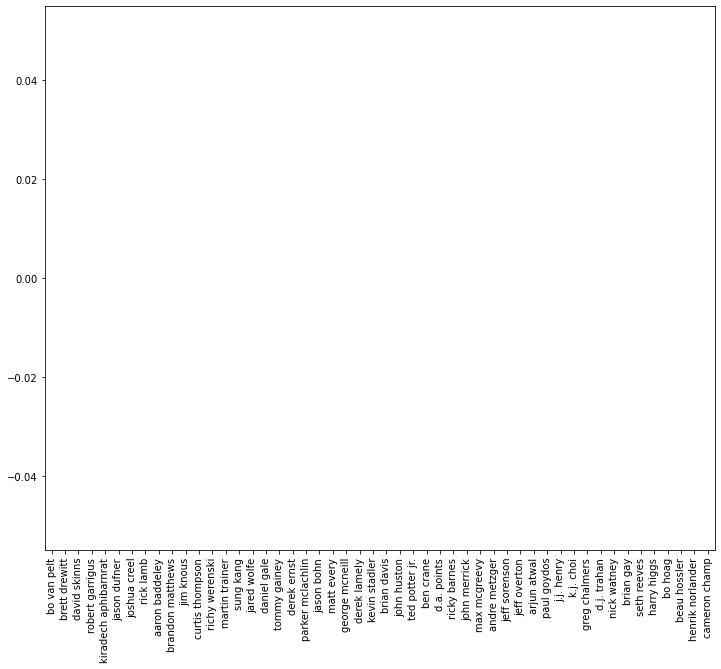

In [24]:
counts_small.sort_values(ascending=False).iloc[50:100].T.plot(kind="bar", figsize=(12, 10))
plt.show()

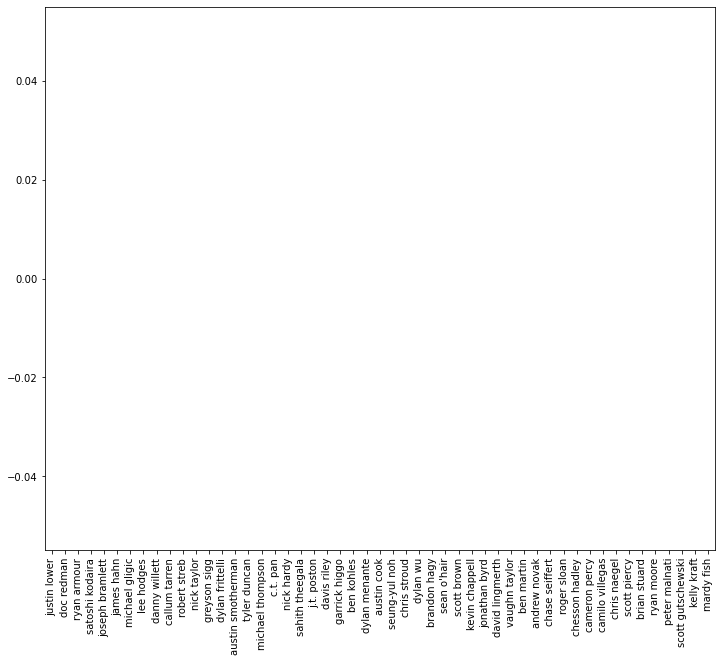

In [25]:
counts_small.sort_values(ascending=False).iloc[100:].T.plot(kind="bar", figsize=(12, 10))
plt.show()